### This file's scope is data preparation and transformation, the output of which to be further used in data visualization and output prediction.
### The dataset focuses on 2 plants and their AC / DC energy output obtained at the inverter level, within 15 minute intervals;
### In addition, we also have weather information data which we can use to predict output. According to various research papers, actual weather data should not be used to forecast energy output, but instead forecasts of weather should be used as predictors; I will still use the actuals in this project, as there's no alternative



In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns


cwd = os.getcwd()


plant_1= pd.read_csv(cwd + "\\Plant_1_Generation_Data.csv", delimiter = ",")

plant_1.columns = map(str.lower, plant_1.columns) #turning the capital column names into lowercase
plant_1['date_time'] = pd.to_datetime(plant_1['date_time'],format ='%d-%m-%Y %H:%M')
plant_1['date'] = plant_1['date_time'].dt.date
plant_1['time'] = plant_1['date_time'].dt.time
plant_1.drop('plant_id', axis = 1, inplace=True)

plant_2= pd.read_csv(cwd + "\\Plant_2_Generation_Data.csv", delimiter = ",")

plant_2.columns = map(str.lower, plant_2.columns)
plant_2['date_time'] = pd.to_datetime(plant_2['date_time'],format ='%Y-%m-%d %H:%M')
plant_2['date'] = plant_2['date_time'].dt.date
plant_2['time'] = plant_2['date_time'].dt.time
plant_2.drop('plant_id', axis = 1, inplace=True)


plant_1

,date_time,source_key,dc_power,ac_power,daily_yield,total_yield,date,time
0,2020-05-15 00:00:00,1BY6WEcLGh8j5v7,0.0,0.0,0.000,6259559.0,2020-05-15,00:00:00
1,2020-05-15 00:00:00,1IF53ai7Xc0U56Y,0.0,0.0,0.000,6183645.0,2020-05-15,00:00:00
2,2020-05-15 00:00:00,3PZuoBAID5Wc2HD,0.0,0.0,0.000,6987759.0,2020-05-15,00:00:00
3,2020-05-15 00:00:00,7JYdWkrLSPkdwr4,0.0,0.0,0.000,7602960.0,2020-05-15,00:00:00
4,2020-05-15 00:00:00,McdE0feGgRqW7Ca,0.0,0.0,0.000,7158964.0,2020-05-15,00:00:00
...,...,...,...,...,...,...,...,...
68773,2020-06-17 23:45:00,uHbuxQJl8lW7ozc,0.0,0.0,5967.000,7287002.0,2020-06-17,23:45:00
68774,2020-06-17 23:45:00,wCURE6d3bPkepu2,0.0,0.0,5147.625,7028601.0,2020-06-17,23:45:00
68775,2020-06-17 23:45:00,z9Y9gH1T5YWrNuG,0.0,0.0,5819.000,7251204.0,2020-06-17,23:45:00
68776,2020-06-17 23:45:00,zBIq5rxdHJRwDNY,0.0,0.0,5817.000,6583369.0,2020-06-17,23:45:00


### Each plant has 22 inverters, each inverter is connected with a number of PV arrays. Every 15 minutes, each inverter records his data; therefore, at any particular 15 minute observation, we have 44 observations of the data (for the 2 plants); to get the total output of the plant, we need to sum the 22 inverters.

In [98]:
#We check for the inverters data accuracy. We know that the PV array receives DC power then converts it to AC power through the inverter, at 95-97% accuracy usually. Let's check that for our plants.

def plant_efficiency(dataframe):
    df = dataframe.copy()
    df['efficiency'] = np.divide(df['ac_power'], df['dc_power'], out=np.zeros_like(df['ac_power']), where=df['dc_power']!=0)      #dividing the AC power by DC power to get the efficiency of the inverter
    df = df[df['efficiency']!=0]   #eliminating 0 efficiency rows to not skew the mean (because there's no power generated during certain times)
    print("Plant efficiency: " + str(df['efficiency'].mean() * 100))
    


plant_efficiency(plant_1)
plant_efficiency(plant_2)

#We can see that the effiency of plant 1 is 10 times lower than that of plant 2

plant_1.loc[:, 'ac_power'] = plant_1.loc[:, 'ac_power'] * 10    #multiplying the AC power by 10 to get the actual power in kW

print ("----------------------------------------")


plant_efficiency(plant_1)
plant_efficiency(plant_2)


Plant efficiency: 9.771886762799628
Plant efficiency: 97.68063442756191
----------------------------------------
Plant efficiency: 97.71886762799626
Plant efficiency: 97.68063442756191


In [99]:
print(plant_1.groupby('source_key').count())

print(plant_2.groupby('source_key').count())


#Seeing that we should have 3264 observations for each inverter (34 days worth of data, 15 min frequency: 34*24*4), it seems like there's missing data for the inverter. So we'll go ahead and compute it.

                 date_time  dc_power  ac_power  daily_yield  total_yield  \
source_key                                                                 
1BY6WEcLGh8j5v7       3154      3154      3154         3154         3154   
1IF53ai7Xc0U56Y       3119      3119      3119         3119         3119   
3PZuoBAID5Wc2HD       3118      3118      3118         3118         3118   
7JYdWkrLSPkdwr4       3133      3133      3133         3133         3133   
McdE0feGgRqW7Ca       3124      3124      3124         3124         3124   
VHMLBKoKgIrUVDU       3133      3133      3133         3133         3133   
WRmjgnKYAwPKWDb       3118      3118      3118         3118         3118   
YxYtjZvoooNbGkE       3104      3104      3104         3104         3104   
ZnxXDlPa8U1GXgE       3130      3130      3130         3130         3130   
ZoEaEvLYb1n2sOq       3123      3123      3123         3123         3123   
adLQvlD726eNBSB       3119      3119      3119         3119         3119   
bvBOhCH3iADS

C:\Users\alexm\AppData\Local\Temp/ipykernel_10520/962333370.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['time'] = data['time'].astype(str)


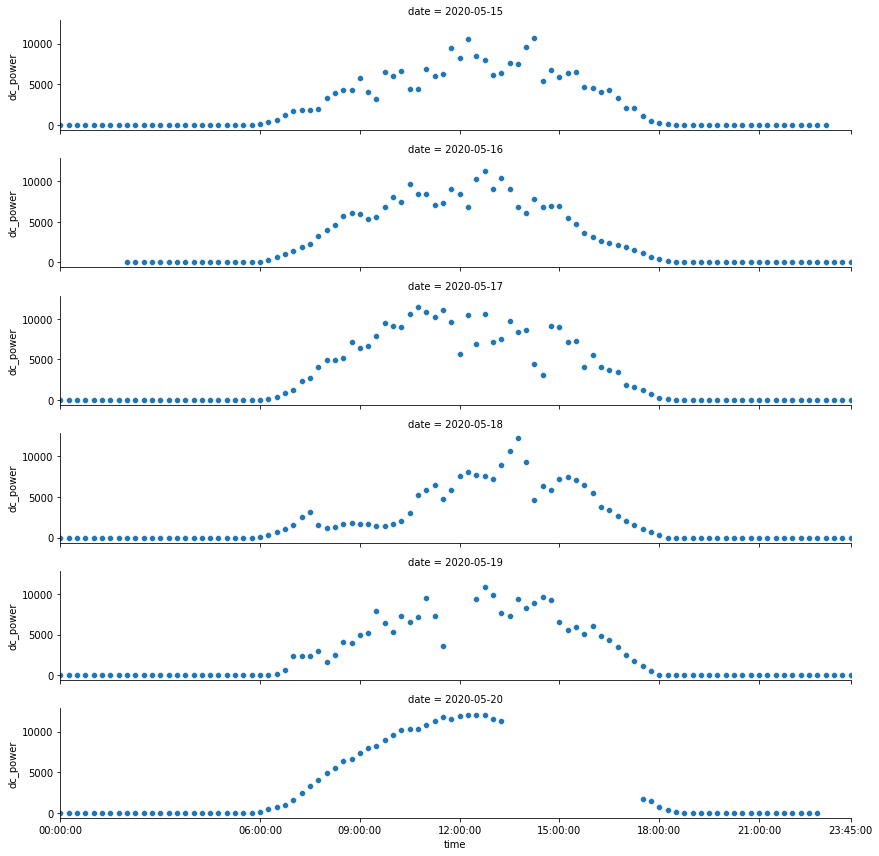

In [100]:
#first of all, we need to find the hours in which there's no sunlight, thus no power; if there is any missing interval during that time, we will compute it with 0 automatically
#for the rest, we'll see what we can do

data = plant_1[(plant_1['source_key']=="1BY6WEcLGh8j5v7") & (plant_1['date_time'].between('2020-05-15','2020-05-21'))]
data['time'] = data['time'].astype(str)
g = sns.relplot(
        data=data,
        x='time',
        y='dc_power',
        row='date',
        kind='scatter',
        height=2,
        aspect=6
        )
    
g.set(xlim=('00:00:00', '23:45:00'), xticks=['00:00:00','06:00:00','09:00:00','12:00:00','15:00:00','18:00:00','21:00:00','23:45:00'])

#from above plot we can see that there is missing data at certain hours, but also that in the interval 18:45 - 05:45, the power is always 0 (no sunshine, of course); we can further check this below


In [101]:
plant_1[plant_1['dc_power']!=0].groupby('time').mean()  #with this we see that there is no data 18:45-05:45


,dc_power,ac_power,daily_yield,total_yield
time,,,,
06:00:00,97.280977,93.896446,0.468064,6.968351e+06
06:15:00,362.607787,350.563731,5.134713,6.974170e+06
06:30:00,703.921205,682.526629,17.727185,6.973943e+06
06:45:00,1126.853275,1096.985578,38.299469,6.975551e+06
07:00:00,1710.096711,1673.320350,72.286173,6.975589e+06
07:15:00,2302.052653,2256.992367,121.113013,6.975638e+06
07:30:00,2790.325790,2738.831751,183.804186,6.975700e+06
07:45:00,3378.022169,3315.774102,259.815508,6.973378e+06
08:00:00,4103.349352,4025.097310,348.652413,6.973469e+06


In [102]:

def fill_missing_inverter_data(dataframe):
    df = dataframe.copy()
    complete_datetime  = pd.DataFrame({'date_time':pd.date_range(start='2020-05-15 00:00',end='2020-06-17 23:45' , freq='15T') }) #dataframe with the complete dates, with a frequency of 15 minutes
    empty_df = pd.DataFrame(columns = df.columns)
    total_inverter_list = list(df.groupby('source_key').count().index)
    for i in total_inverter_list:
        inverter_data = df[df['source_key'] == i].reset_index(drop=True)  

        left_join = pd.merge(complete_datetime, inverter_data, on = 'date_time', how='left')
        #now that we have the dataset with the complete dates, we can fill the missing values
        #left_join.isna().sum() 


        left_join.index = left_join['date_time']  #datetime index for easier subsetting
        left_join.drop(['date_time'], axis=1, inplace=True)

        left_join['source_key'] = i   #fill source key with the inverter key we are currently analysing
        left_join['date'] = left_join.index.date
        left_join['time'] = left_join.index.time

        morning = left_join.between_time('00:00:00','05:45:00')
        midday  = left_join.between_time('06:00:00','18:30:00')
        night   = left_join.between_time('18:45:00','23:45:00')

        #fill with 0 if within the interval 18:45-05:45, otherwise fill with the mean of the inverter
        morning['dc_power'].fillna(value=0, inplace=True)
        morning['ac_power'].fillna(value=0, inplace=True)
        morning['daily_yield'].fillna(value =0, inplace=True)

        night['dc_power'].fillna(value=0, inplace=True)
        night['ac_power'].fillna(value=0, inplace=True)
        night['daily_yield'].fillna(method='ffill', inplace=True)  #we fill na values with values from the previous available row

        #for midday values, we can use the interpolate function
        new_concat = pd.DataFrame()
        new_concat = pd.concat([morning,midday, night])
        new_concat = new_concat.sort_index()
        new_concat[['ac_power','dc_power','daily_yield']] = new_concat[['ac_power','dc_power','daily_yield']].interpolate(method='time')
        new_concat['total_yield'] = new_concat['total_yield'].interpolate(method='time')
        new_concat.reset_index(inplace=True)
       
        empty_df = pd.concat([empty_df, new_concat])  #concat each inverter data back
        empty_df.reset_index(drop=True)
    return empty_df


df_plant_1 = fill_missing_inverter_data(plant_1)
df_plant_2 = fill_missing_inverter_data(plant_2)



C:\Users\alexm\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [103]:
print(df_plant_1.groupby('source_key').count())

print(df_plant_2.groupby('source_key').count())

#that each inverter now has 3264 observations, so the problem was fixed

                 date_time  dc_power  ac_power  daily_yield  total_yield  \
source_key                                                                 
1BY6WEcLGh8j5v7       3264      3264      3264         3264         3264   
1IF53ai7Xc0U56Y       3264      3264      3264         3264         3264   
3PZuoBAID5Wc2HD       3264      3264      3264         3264         3264   
7JYdWkrLSPkdwr4       3264      3264      3264         3264         3264   
McdE0feGgRqW7Ca       3264      3264      3264         3264         3264   
VHMLBKoKgIrUVDU       3264      3264      3264         3264         3264   
WRmjgnKYAwPKWDb       3264      3264      3264         3264         3264   
YxYtjZvoooNbGkE       3264      3264      3264         3264         3260   
ZnxXDlPa8U1GXgE       3264      3264      3264         3264         3264   
ZoEaEvLYb1n2sOq       3264      3264      3264         3264         3264   
adLQvlD726eNBSB       3264      3264      3264         3264         3264   
bvBOhCH3iADS

### Summary: we found two majors problems in our dataset.
### First, the first plant's data was corrupted in the sense that the AC_power was somehow divided by 10, so we had to multiply it by 10 to get the correct data
### Secondly, the inverters had missing data, so we had to interpolate (based on what time the missing data was located at) to get the full 34 days worth of data

## Weather Sensor Data

In [104]:
weather_plant_1= pd.read_csv(cwd + "\\Plant_1_Weather_Sensor_Data.csv", delimiter = ",")

weather_plant_1.columns = map(str.lower, weather_plant_1.columns) #turning the capital column names into lowercase
weather_plant_1['date_time'] = pd.to_datetime(weather_plant_1['date_time'],format ='%Y-%m-%d %H:%M')
weather_plant_1.drop(columns = ['plant_id', 'source_key'], axis = 1, inplace=True)



weather_plant_2= pd.read_csv(cwd + "\\Plant_2_Weather_Sensor_Data.csv", delimiter = ",")

weather_plant_2.columns = map(str.lower, weather_plant_2.columns) #turning the capital column names into lowercase
weather_plant_2['date_time'] = pd.to_datetime(weather_plant_2['date_time'],format ='%Y-%m-%d %H:%M')
weather_plant_2.drop(columns = ['plant_id', 'source_key'], axis = 1, inplace=True)

weather_plant_2

,date_time,ambient_temperature,module_temperature,irradiation
0,2020-05-15 00:00:00,27.004764,25.060789,0.0
1,2020-05-15 00:15:00,26.880811,24.421869,0.0
2,2020-05-15 00:30:00,26.682055,24.427290,0.0
3,2020-05-15 00:45:00,26.500589,24.420678,0.0
4,2020-05-15 01:00:00,26.596148,25.088210,0.0
...,...,...,...,...
3254,2020-06-17 22:45:00,23.511703,22.856201,0.0
3255,2020-06-17 23:00:00,23.482282,22.744190,0.0
3256,2020-06-17 23:15:00,23.354743,22.492245,0.0
3257,2020-06-17 23:30:00,23.291048,22.373909,0.0


In [105]:
# The weather data is missing a few observations, but since the data applies to all inverters, we can just interpolate the 3 numeric fields to fill in the missing data


def fill_missing_weather_data(dataframe):
    df = dataframe.copy()
    complete_datetime  = pd.DataFrame({'date_time':pd.date_range(start='2020-05-15 00:00',end='2020-06-17 23:45' , freq='15T') }) #dataframe with the complete dates, with a frequency of 15 minutes
    full_df = pd.merge(df, complete_datetime, how = 'outer')

    full_df.index = full_df['date_time']  #datetime index for interpolate
    full_df[['module_temperature', 'ambient_temperature', 'irradiation']] = full_df[['module_temperature', 'ambient_temperature', 'irradiation']].interpolate(method='time')
    full_df.reset_index(drop = True, inplace=True)
    return full_df

complete_weather_plant_1 = fill_missing_weather_data(weather_plant_1)
complete_weather_plant_2 = fill_missing_weather_data(weather_plant_2)

print("Lenght of plant 1 sensor dataframe before filling missing values was " + str(len(weather_plant_1)) + " , after filling missing values it is " + str(len(complete_weather_plant_1)))
print("Lenght of plant 2 sensor dataframe before filling missing values was " + str(len(weather_plant_2)) + " , after filling missing values it is " + str(len(complete_weather_plant_2)))


Lenght of plant 1 sensor dataframe before filling missing values was 3182 , after filling missing values it is 3264
Lenght of plant 2 sensor dataframe before filling missing values was 3259 , after filling missing values it is 3264


In [108]:
#let's combine the generation and weather data

solar_plant_1 = pd.merge(df_plant_1, complete_weather_plant_1, on = 'date_time', how = 'inner')
solar_plant_1['plant'] = "plant_1"
solar_plant_2 = pd.merge(df_plant_2, complete_weather_plant_1, on = 'date_time', how = 'inner')
solar_plant_2['plant'] = "plant_2"

df = pd.concat([solar_plant_1, solar_plant_2])

df.to_csv('complete_data.csv')
solar_plant_1.to_csv('plant_1_data.csv')
solar_plant_2.to_csv('plant_2_data.csv')


## We now have a full dataframe with both plants and their respective sensor weather data and energy generation, as well as 2 dataframes with each plant separately; we can use these further in analysis